In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt


**Load Data Files**

In [3]:
data_files = ['recipes_raw_nosource_ar.json', 'recipes_raw_nosource_epi.json', 'recipes_raw_nosource_fn.json']

In [4]:
values = []
for data_file in data_files:
  with open(data_file, 'r') as f:
    data = json.load(f)
  for k, v in data.items():
    values.append({'title': v.get('title', None), 'ingredients': v.get('ingredients', None), 'instructions': v.get('instructions', None), 'source': data_file})
  
df = pd.DataFrame(values)

In [141]:
df.head()

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,ingredients,instructions,source
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",recipes_raw_nosource_ar.json
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",recipes_raw_nosource_ar.json
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....,recipes_raw_nosource_ar.json
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....,recipes_raw_nosource_ar.json
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...,recipes_raw_nosource_ar.json


**Number of Records Per Data Source**

In [5]:
df.groupby('source').size()

source
recipes_raw_nosource_ar.json     39802
recipes_raw_nosource_epi.json    25323
recipes_raw_nosource_fn.json     60039
dtype: int64

**Percentage of Records with Missing Information**

In [6]:
df[['title', 'ingredients', 'instructions']].isnull().sum() * 100 / len(df)

title           0.454604
ingredients     0.413058
instructions    0.552076
dtype: float64

In [7]:
df_nona = df.dropna().copy()
print(f'Number of records dropped: {len(df)-len(df_nona)}')


Number of records dropped: 691


**Text Processing**

---



Tokenzation:

In [8]:
import spacy
from functools import partial
from tqdm import tqdm
tqdm.pandas()
import swifter

In [128]:
my_stop_words = ['ounce', 'teaspoon', 'tablespoon', 'minutes', 'cup', 'glass', 'remove', 'add', 'plate', 'tablespoons', 'ounces', 'bowl', 'plastic']
nlp = spacy.load("en_core_web_sm", disable=[ "ner", "parser", "tok2vec"])
def tokenize(nlp, text):
  tok = nlp(text)
  return [t.lemma_ for t in tok if (not t.is_stop) and t.is_alpha and t.lemma_ not in my_stop_words]
tok_nlp = partial(tokenize, nlp)

df_nona['tokenized_title'] = df_nona.progress_apply(lambda r: tok_nlp(r['title']), axis=1)
df_nona['tokenized_ingredients'] = df_nona.progress_apply(lambda r: [tok_nlp(i) for i in r['ingredients']], axis=1)
df_nona['tokenized_instructions'] = df_nona.progress_apply(lambda r: tok_nlp(r['instructions']), axis=1)

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 124473/124473 [13:07<00:00, 158.10it/s]


In [129]:
import itertools

df_nona['all_tokenized'] = df_nona.apply(lambda x: x['tokenized_title'] + list(itertools.chain.from_iterable(x['tokenized_ingredients'])) + x['tokenized_instructions'], axis=1)

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [142]:
df_nona.head()

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,ingredients,instructions,source,tokenized_title,tokenized_ingredients,tokenized_instructions,all_tokenized,bow
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",recipes_raw_nosource_ar.json,"[slow, cooker, chicken, dumplings]","[[skinless, boneless, chicken, breast, halves,...","[place, chicken, butter, soup, onion, slow, co...","[slow, cooker, chicken, dumplings, skinless, b...","[(0, 6), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",recipes_raw_nosource_ar.json,"[awesome, slow, cooker, pot, roast]","[[cans, condensed, cream, mushroom, soup, adve...","[slow, cooker, mix, cream, mushroom, soup, dry...","[awesome, slow, cooker, pot, roast, cans, cond...","[(0, 5), (5, 1), (8, 1), (9, 1), (10, 3), (12,..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....,recipes_raw_nosource_ar.json,"[brown, sugar, meatloaf]","[[packed, brown, sugar, advertisement], [ketch...","[preheat, oven, degrees, f, degrees, c, lightl...","[brown, sugar, meatloaf, packed, brown, sugar,...","[(0, 11), (17, 1), (22, 1), (25, 1), (39, 1), ..."
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....,recipes_raw_nosource_ar.json,"[best, chocolate, chip, cookies]","[[butter, softened, advertisement], [white, su...","[preheat, oven, degrees, f, degrees, c, cream,...","[best, chocolate, chip, cookies, butter, softe...","[(0, 12), (4, 2), (12, 1), (33, 2), (36, 2), (..."
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...,recipes_raw_nosource_ar.json,"[homemade, mac, cheese, casserole]","[[wheat, rotini, pasta, advertisement], [cups,...","[preheat, oven, degrees, line, quart, casserol...","[homemade, mac, cheese, casserole, wheat, roti...","[(0, 14), (4, 3), (9, 3), (12, 2), (22, 2), (2..."


In [130]:
from gensim.test.utils import common_texts

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
common_dictionary = Dictionary(df_nona['all_tokenized'])

df_nona['bow'] = [common_dictionary.doc2bow(text) for text in df_nona['all_tokenized']]

lda = LdaModel(df_nona['bow'], num_topics=20)

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
def format_topics_sentences(ldamodel, corpus, texts, common_dictionary):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in tqdm(enumerate(ldamodel[corpus]), total=len(corpus)):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
topic_documents = format_topics_sentences(lda, df_nona['bow'], df_nona['title'], common_dictionary)

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 124473/124473 [18:55<00:00, 109.60it/s]


In [144]:
topic_documents.dropna()

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,title
0,7.0,0.4191,Slow Cooker Chicken and Dumplings
1,8.0,0.3497,Awesome Slow Cooker Pot Roast
2,12.0,0.5828,Brown Sugar Meatloaf
3,1.0,0.7103,Best Chocolate Chip Cookies
4,6.0,0.3443,Homemade Mac and Cheese Casserole
...,...,...,...
124468,17.0,0.3092,Tuna Tostada with Watermelon Slaw
124469,19.0,0.4022,Apple-Raspberry Crumb Bars
124470,19.0,0.3718,Grilled Pork Tenderloin with a Basic Dry Rub
124471,16.0,0.5981,Basil Chive Red Potato Mash


In [136]:
def select_top(group, top=10, column="Perc_Contribution"):
    return group.sort_values(column, ascending=False).iloc[0:top]
topk_per_topic = topic_documents.groupby('Dominant_Topic').apply(select_top).reset_index(drop=True)


/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
topk_per_topic[topk_per_topic.Dominant_Topic == 7]

/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,title
70,7.0,0.7871,Poulet de Provencal
71,7.0,0.7819,Chicken Taco Filling
72,7.0,0.7684,Pineapple-Orange Punch
73,7.0,0.7667,Baked Fettuccine Lasagna
74,7.0,0.7554,Slow Cooker Adobo Chicken
75,7.0,0.7320,Honey-Garlic Slow Cooker Chicken Thighs
76,7.0,0.7095,Curry Chicken Salad
77,7.0,0.6952,A Good Easy Garlic Chicken
78,7.0,0.6762,Tincho Tropical
79,7.0,0.6753,Slow Cooker Honey Garlic Chicken


/home/moti/ds_py/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


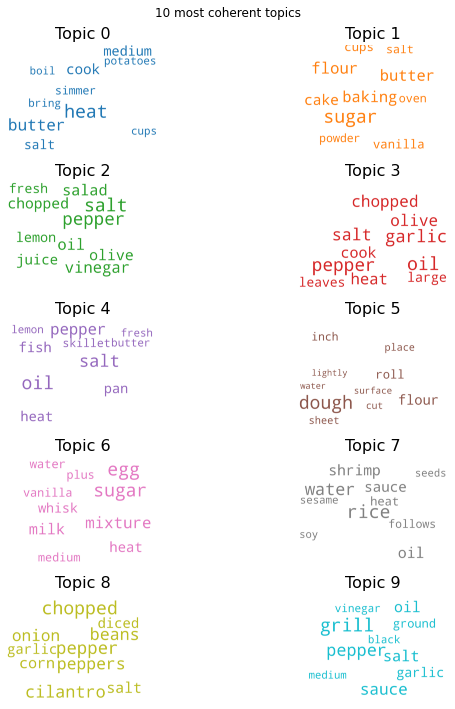

In [138]:
#Display most coherent topics (top 10)

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nlp.Defaults.stop_words & set(my_stop_words),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.top_topics(corpus=df_nona['bow'], dictionary=common_dictionary)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle("10 most coherent topics")
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = topics[i][0]
    topic_words = {common_dictionary[int(w)]: p for p,w in topic_words}
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()